In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms

import torch.nn as nn

In [17]:
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix


def infer_single_sample(test_loader, model):
    # Poner el modelo en modo evaluación
    model.eval()

    # Seleccionar imagen random
    test_iter = iter(test_loader)
    images1, images2, labels = next(test_iter)  # Toma el primer batch del loader
    idx = random.randint(0, len(labels) - 1)
    
    print(images1.shape)

    img1, img2, label = images1[idx].unsqueeze(0), images2[idx].unsqueeze(0), labels[idx].unsqueeze(0)

    img1, img2, label = img1.to(device), img2.to(device), label.to(device)

    print(img1.shape)

    with torch.no_grad():
        output = model(img1, img2)
        prediction = (output > 0.5).float()  # Binarizar la predicción

    # Mostrar las imágenes y los resultados
    img1_np = img1.squeeze().cpu().numpy().transpose(1, 2, 0)
    img2_np = img2.squeeze().cpu().numpy().transpose(1, 2, 0)

    plt.figure(figsize=(8,4))

    # Mostrar la primera imagen
    plt.subplot(1, 2, 1)
    plt.imshow(img1_np)
    plt.title("Image 1")

    # Mostrar la segunda imagen
    plt.subplot(1, 2, 2)
    plt.imshow(img2_np)
    plt.title("Image 2")

    plt.show()

    # Imprimir la etiqueta verdadera y la predicción
    print(f"True Label: {label.item()}")
    print(f"Predicted Label: {prediction.item()}")

# Función para realizar inferencia y calcular métricas
def evaluate_model(test_loader, model):
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for img1, img2, label in test_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            # Realizar inferencia
            outputs = model(img1, img2)
            predictions = (outputs > 0.5).float()  # Binarizar las predicciones

            # Guardar etiquetas y predicciones
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Calcular las métricas
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=1)
    recall = recall_score(all_labels, all_predictions, zero_division=1)

    # Calcular matriz de confusión
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return accuracy, precision, recall, conf_matrix


## Test and compare models 

Se ejecuta cada modelo en: 

- Set de test
- Set de clases no vistas por el modelo

### Simple Siamese model

In [6]:
import torch
import torch.nn as nn
import seaborn as sns
from src.models.simple_siamese_network import SimpleSiameseNetwork

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inicializar la red y la función de pérdida
model = SimpleSiameseNetwork()
model.load_state_dict(torch.load('checkpoints/SimpleSiameseNetwork_v2_ultimo.pth'))
model.to(device)
model.eval()  # Cambiar el modelo a modo evaluación

SimpleSiameseNetwork(
  (convnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=36864, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=256, bias=True)
  )
  (distance_layer): Linear(in_features=256, out_features=1, bias=True)
)

#### Dataset de Test

In [36]:
from src.dataset import SiameseDataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
    ])

test_dataset = SiameseDataset(
    "data/cropped_selected_split_data/test",
    transform = transform,
    max_positive_combinations=3,
    max_negative_combinations=5
    )

test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1)

Test Accuracy: 0.9464
Test Precision: 0.8361
Test Recall: 0.9387


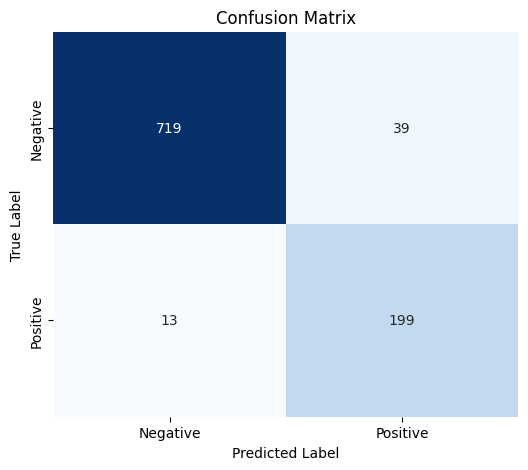

In [37]:
# Inferencia sobre el test_loader
test_accuracy, test_precision, test_recall, conf_matrix = evaluate_model(test_loader, model)

# Imprimir los resultados
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

#### Testeo en datos no vistos

In [38]:
from src.dataset import SiameseDataset

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
    ])

unseen_dataset = SiameseDataset(
    "data/cropped_not_used_classes",
    transform = transform,
    max_positive_combinations=3,
    max_negative_combinations=5
    )

unseen_loader = DataLoader(unseen_dataset, shuffle=False, batch_size=1)



In [5]:
torch.cuda.empty_cache()

Test Accuracy: 0.8890
Test Precision: 0.7909
Test Recall: 0.9456


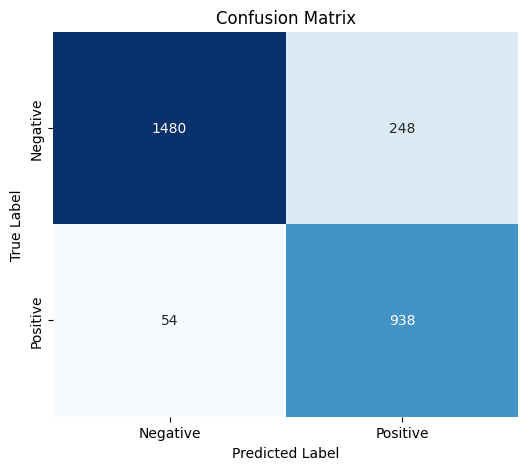

In [39]:
# Inferencia sobre el test_loader
test_accuracy, test_precision, test_recall, conf_matrix = evaluate_model(unseen_loader, model)

# Imprimir los resultados
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

torch.Size([4, 3, 256, 256])
torch.Size([1, 3, 256, 256])


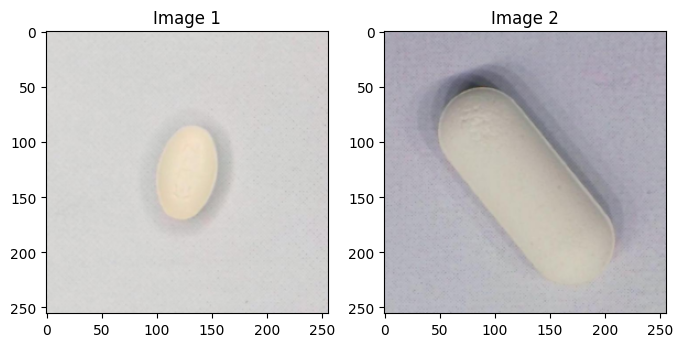

True Label: 0.0
Predicted Label: 0.0


In [20]:
# Ejecutar inferencia sobre un sample aleatorio del test_loader
infer_single_sample(unseen_loader, model)

torch.Size([4, 3, 256, 256])
torch.Size([1, 3, 256, 256])


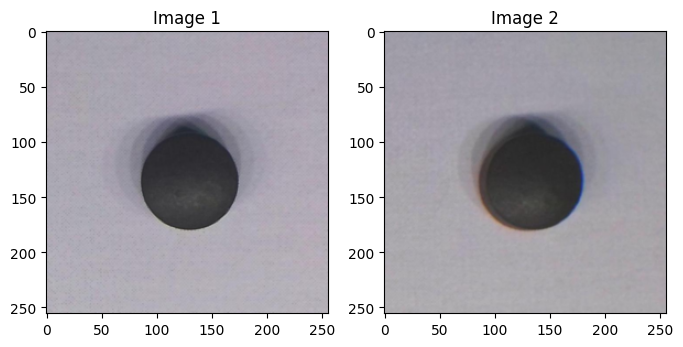

True Label: 1.0
Predicted Label: 1.0


In [24]:
# Ejecutar inferencia sobre un sample aleatorio del test_loader
infer_single_sample(unseen_loader, model)

torch.Size([4, 3, 256, 256])
torch.Size([1, 3, 256, 256])


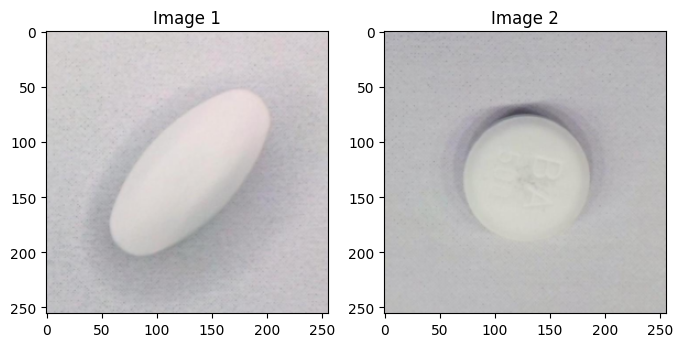

True Label: 0.0
Predicted Label: 1.0


In [22]:
# Ejecutar inferencia sobre un sample aleatorio del test_loader
infer_single_sample(unseen_loader, model)

torch.Size([4, 3, 256, 256])
torch.Size([1, 3, 256, 256])


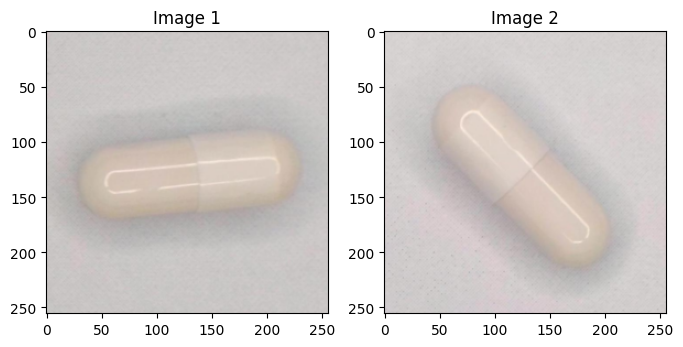

True Label: 1.0
Predicted Label: 1.0


In [31]:
# Ejecutar inferencia sobre un sample aleatorio del test_loader
infer_single_sample(unseen_loader, model)

### Resnet based models